In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import torch module
import torch
from torch import nn
from torch.autograd import Variable

torch.backends.cudnn.benchmark = True

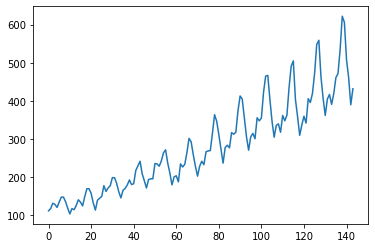

In [2]:
data_csv = pd.read_csv('./data/AirPassengers.csv', usecols=[1])
# data_csv = pd.read_csv('./data/0.csv', usecols=[0])
plt.plot(data_csv)

In [3]:
# data clean
data_csv = data_csv.dropna()
dataset = data_csv.values
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, dataset))

In [4]:
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i: (i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

# build input and output
data_X, data_Y = create_dataset(dataset)

In [5]:
train_size = int(len(data_X) * 0.7)
test_size = len(data_X) - train_size
train_X, train_Y = data_X[: train_size], data_Y[: train_size]
test_X, test_Y = data_X[train_size:], data_Y[train_size:]

In [6]:
train_X = train_X.reshape(-1, 1, 2)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2)

train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)

In [7]:
class LSTM(nn.Module):
    def __init__(self, input_size=2, hidden_size=4, output_size=1, num_layer=2):
        super(LSTM, self).__init__()
        self.layer1 = nn.LSTM(input_size, hidden_size, num_layer)
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.layer1(x)
        s, b, h = x.size()
        x = x.view(s * b, h)
        x = self.layer2(x)
        x = x.view(s, b, -1)
        return x

model = LSTM(2, 4, 1, 2)

In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [9]:
# start training

for e in range(3000):
    var_x, var_y = Variable(train_x), Variable(train_y)
    
    out = model(var_x)
    loss = criterion(out, var_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [10]:
model = model.eval()

data_X = data_X.reshape(-1, 1, 2)
data_X = torch.from_numpy(data_X)
var_data = Variable(data_X)
pred_test = model(var_data)

pred_test = pred_test.view(-1).data.numpy()

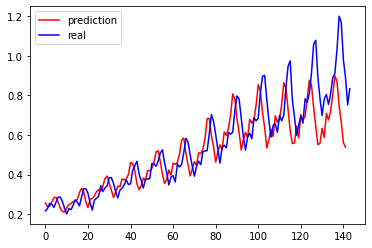

In [11]:
plt.plot(pred_test, 'r', label='prediction')
plt.plot(dataset, 'b', label='real')
plt.legend(loc='best')